# Biostat M280 Homework 2
# Sarah Ji
**Due May 11 @ 11:59PM**

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).
In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

In [19]:
function nnmf(
    X::Matrix, 
    r::Int;
    maxiter::Int=1000, 
    tol::eltype(X)=1e-4,
    V::Matrix{eltype(X)}=rand(size(X, 1), r),
    W::Matrix{eltype(X)}=rand(r, size(X, 2))
    )
    #implementation
    
end

nnmf (generic function with 1 method)

In [20]:
#Pkg.add("ImageView")
using ImageView

X = readdlm("nnmf-2429-by-361-face.txt")
img1 = X[1,:]
img1 = reshape(img1, 19, 19)
img2 = X[2,:]
img2 = reshape(img2, 19, 19)
img3 = X[10, :]
img3 = reshape(img3, 19, 19)
img4 = X[125, :]
img4 = reshape(img4, 19, 19)
img5 = X[130, :]
img5 = reshape(img5, 19, 19)

19×19 Array{Float64,2}:
 0.0       0.015471   0.17109   0.37858   …  0.41316   0.30077   0.19703
 0.0       0.0        0.0       0.0          0.041407  0.09328   0.24025
 0.0       0.0        0.27483   0.78492      1.0       0.48233   0.18838
 0.17109   0.0        0.0       0.65523      0.23161   0.37858   0.0    
 0.0       0.0        0.0       0.0          0.0       0.0       0.0    
 0.12786   0.13651    0.015471  0.058698  …  0.24025   0.37858   0.20567
 0.21432   0.28348    0.25754   0.344        0.47368   0.52555   0.29213
 0.20567   0.32671    0.30942   0.43045      0.46503   0.46503   0.52555
 0.16244   0.20567    0.14515   0.27483      0.28348   0.54284   0.46503
 0.11057   0.26619    0.45639   0.5342       0.70711   0.60336   0.44774
 0.084635  0.22296    0.4391    0.49097   …  0.64659   0.51691   0.36993
 0.058698  0.11922    0.29213   0.36993      0.56013   0.42181   0.32671
 0.050053  0.050053   0.19703   0.26619      0.48233   0.38723   0.29213
 0.024117  0.032762   0.222

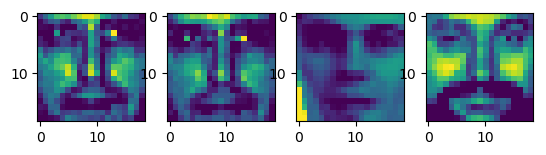

PyObject <matplotlib.image.AxesImage object at 0x1377935d0>

In [26]:
using PyPlot

subplot(1, 4, 1)
PyPlot.imshow(img1)
subplot(1, 4, 2)
PyPlot.imshow(img2)
subplot(1, 4, 3)
PyPlot.imshow(img3)
subplot(1, 4, 4)
PyPlot.imshow(img4)

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

## Q2.1 Solution:

In [27]:
# better memory efficiency
function logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number)
    n = length(y)
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    Σchol = cholfact(Symmetric(Σ))
    - (n//2) * log(2π) - (1//2) * logdet(Σchol) - (1//2) * dot(y, Σchol \ y)
end

logpdf_mvn (generic function with 1 method)

In [28]:
using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
   # @benchmark logpdf(mvn, y)

logpdf_mvn(y, Z, σ0, σ1) = -1571.5736734654133
logpdf(mvn, y) = -1571.5736734654135


BenchmarkTools.Trial: 
  memory estimate:  91.87 MiB
  allocs estimate:  18
  --------------
  minimum time:     174.794 ms (11.85% GC)
  median time:      209.898 ms (10.14% GC)
  mean time:        221.138 ms (12.81% GC)
  maximum time:     380.554 ms (48.39% GC)
  --------------
  samples:          23
  evals/sample:     1